## Prepare Notebook

In [1]:
import arviz as az
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.special import expit
from sklearn.preprocessing import MinMaxScaler


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Data

In [2]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


class CohortDataGenerator:
    def __init__(
        self,
        rng: np.random.Generator,
        start_cohort: str,
        n_cohorts,
        user_base: int = 10_000,
    ) -> None:
        self.rng = rng
        self.start_cohort = start_cohort
        self.n_cohorts = n_cohorts
        self.user_base = user_base

    def _generate_cohort_labels(self) -> pd.DatetimeIndex:
        return pd.period_range(
            start="2020-01-01", periods=self.n_cohorts, freq="M"
        ).to_timestamp()

    def _generate_cohort_sizes(self) -> npt.NDArray[np.int_]:
        ones = np.ones(shape=self.n_cohorts)
        trend = ones.cumsum() / ones.sum()
        return (
            (self.user_base * trend * rng.gamma(shape=1, scale=1, size=self.n_cohorts))
            .round()
            .astype(int)
        )

    def _generate_dataset_base(self) -> pd.DataFrame:
        cohorts = self._generate_cohort_labels()
        n_users = self._generate_cohort_sizes()
        data_df = pd.merge(
            left=pd.DataFrame(data={"cohort": cohorts, "n_users": n_users}),
            right=pd.DataFrame(data={"period": cohorts}),
            how="cross",
        )
        data_df["age"] = (data_df["period"].max() - data_df["cohort"]).dt.days
        data_df["cohort_age"] = (data_df["period"] - data_df["cohort"]).dt.days
        data_df = data_df.query("cohort_age >= 0")
        return data_df

    def _generate_retention_rates(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["retention_true_mu"] = (
            - data_df["cohort_age"] / (data_df["age"] + 1)
            + 0.8 * np.cos(2 * np.pi * data_df["period"].dt.dayofyear / 365)
            + 0.5 * np.sin(2 * 3 * np.pi * data_df["period"].dt.dayofyear / 365)
            - 0.5 * np.log1p(data_df["age"])
            + 1.0
        )
        data_df["retention_true"] = expit(data_df["retention_true_mu"])
        return data_df

    def _generate_user_history(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["n_active_users"] = rng.binomial(
            n=data_df["n_users"], p=data_df["retention_true"]
        )
        data_df["n_active_users"] = np.where(
            data_df["cohort_age"] == 0, data_df["n_users"], data_df["n_active_users"]
        )
        return data_df

    def run(
        self,
    ) -> pd.DataFrame:
        return (
            self._generate_dataset_base()
            .pipe(self._generate_retention_rates)
            .pipe(self._generate_user_history)
        )


In [3]:
cohort_generator = CohortDataGenerator(rng=rng, start_cohort="2020-01-01", n_cohorts=35)
data_df = cohort_generator.run()

data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      206 2020-01-01  1035           0          -1.645870   
1 2020-01-01      206 2020-02-01  1035          31          -1.321493   
2 2020-01-01      206 2020-03-01  1035          60          -2.135769   
3 2020-01-01      206 2020-04-01  1035          91          -3.069352   
4 2020-01-01      206 2020-05-01  1035         121          -2.983719   

   retention_true  n_active_users  
0        0.161668             206  
1        0.210570              40  
2        0.105669              24  
3        0.044389               7  
4        0.048167              10

In [4]:
data_df["retention"] = data_df["n_active_users"] / data_df["n_users"]

## EDA

In [5]:
fig, ax = plt.subplots(figsize=(18, 7))

fmt = lambda y, _: f"{y :0.0%}"

(
    data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period");

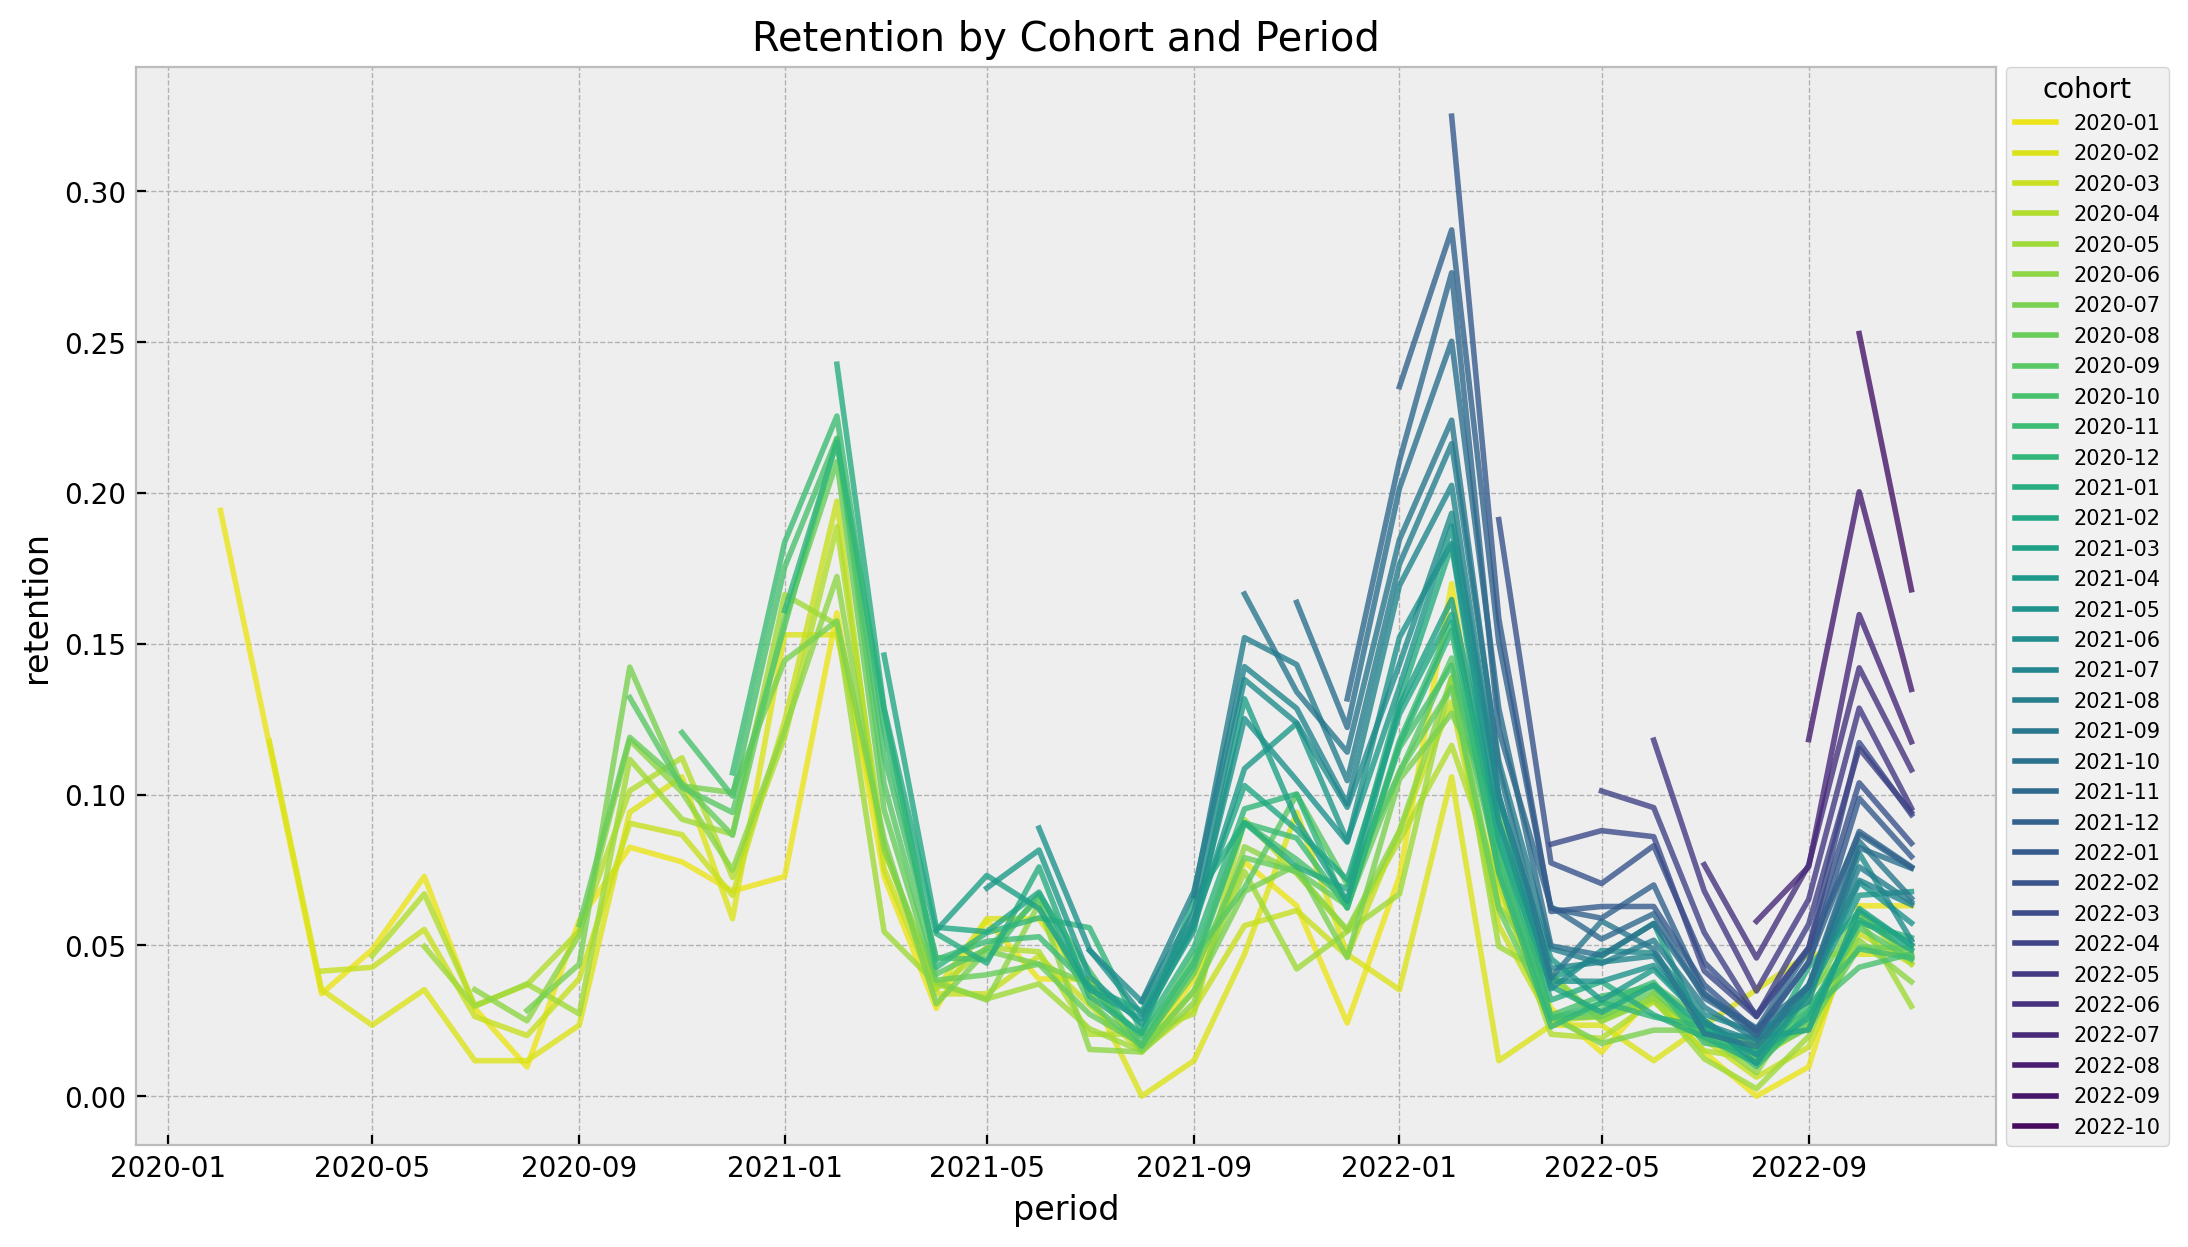

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

In [7]:
g = sns.relplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    col="month",
    col_wrap=3,
    kind="line",
    marker="o",
    alpha=0.8,
    data=data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        month=lambda df: df["period"].dt.strftime("%b")
    ),
    height=2,
    aspect=3,
    facet_kws={"sharex": True, "sharey": True},
)

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="cohort_age",
    y="retention",
    hue="period",
    palette="viridis_r",
    alpha=0.8,
    data=data_df.query("cohort_age > 0").assign(
        period=lambda df: df["period"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="period", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

## Model

In [9]:
data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      206 2020-01-01  1035           0          -1.645870   
1 2020-01-01      206 2020-02-01  1035          31          -1.321493   
2 2020-01-01      206 2020-03-01  1035          60          -2.135769   
3 2020-01-01      206 2020-04-01  1035          91          -3.069352   
4 2020-01-01      206 2020-05-01  1035         121          -2.983719   

   retention_true  n_active_users  retention  
0        0.161668             206   1.000000  
1        0.210570              40   0.194175  
2        0.105669              24   0.116505  
3        0.044389               7   0.033981  
4        0.048167              10   0.048544

In [24]:
data_red_df = data_df.query("cohort_age > 0").reset_index(drop=True)
obs_idx = data_red_df.index.to_numpy()
cohort_idx, cohort = data_red_df["cohort"].factorize()
period_idx, period = data_red_df["period"].factorize()
n_users = data_red_df["n_users"].to_numpy()
n_active_users = data_red_df["n_active_users"].to_numpy()
age = data_red_df["age"].to_numpy()
age_scaler = MinMaxScaler()
age_scaled = age_scaler.fit_transform(age.reshape(-1, 1)).flatten()
cohort_age = data_red_df["cohort_age"].to_numpy()
cohort_age_scaler = MinMaxScaler()
cohort_age_scaled = age_scaler.fit_transform(cohort_age.reshape(-1, 1)).flatten()
period_month_idx, period_month = data_red_df["period"].dt.strftime("%b").factorize()
retention = data_red_df["retention"].to_numpy()


coords: dict[str, npt.NDArray] = {
    "obs": obs_idx,
    "cohort": cohort,
    "period": period,
    "period_month": period_month,
}

In [32]:
with pm.Model(coords=coords) as model:

    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=1)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=1)
    b_period_month = pm.ZeroSumNormal(
        name="b_period_month", sigma=1, dims="period_month"
    )

    mu = pm.Deterministic(
        name="mu",
        var=intercept
        + b_age_scaled * age_scaled
        + b_cohort_age_scaled * cohort_age_scaled
        + b_period_month[period_month_idx],
        dims="obs",
    )

    pm.Binomial(
        name="likelihood",
        n=n_users,
        p=pm.math.invlogit(mu),
        observed=n_active_users,
        dims="obs",
    )

pm.model_to_graphviz(model=model)


In [33]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=2_000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:03.808651
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:06.068468
Transforming variables...


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


Transformation time =  0:00:00.417120


In [34]:
az.summary(data=idata, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept           -1.972  0.007  -1.985   -1.959        0.0      0.0   
b_age_scaled        -0.395  0.018  -0.430   -0.362        0.0      0.0   
b_cohort_age_scaled -1.715  0.024  -1.761   -1.671        0.0      0.0   
b_period_month[Feb]  1.191  0.009   1.175    1.208        0.0      0.0   
b_period_month[Mar]  0.442  0.010   0.422    0.461        0.0      0.0   
b_period_month[Apr] -0.469  0.014  -0.497   -0.442        0.0      0.0   
b_period_month[May] -0.411  0.014  -0.437   -0.385        0.0      0.0   
b_period_month[Jun] -0.171  0.011  -0.192   -0.152        0.0      0.0   
b_period_month[Jul] -0.699  0.012  -0.722   -0.675        0.0      0.0   
b_period_month[Aug] -1.188  0.015  -1.217   -1.161        0.0      0.0   
b_period_month[Sep] -0.407  0.011  -0.427   -0.387        0.0      0.0   
b_period_month[Oct]  0.432  0.008   0.417    0.447        0.0      0.0   
b_period_month[Nov]  0.270  0.008   0.254    0.285        0.0      0.0   
b_period_month[Dec]  0.159  0.014   0.132    0.185        0.0      0.0   
b_period_month[Jan]  0.851  0.010   0.833    0.869        0.0      0.0   

                     ess_bulk  ess_tail  r_hat  
intercept              7568.0    6051.0    1.0  
b_age_scaled           5683.0    5132.0    1.0  
b_cohort_age_scaled    7812.0    5934.0    1.0  
b_period_month[Feb]   14116.0    5890.0    1.0  
b_period_month[Mar]   15883.0    6191.0    1.0  
b_period_month[Apr]   12277.0    5811.0    1.0  
b_period_month[May]   13961.0    5435.0    1.0  
b_period_month[Jun]   15417.0    6205.0    1.0  
b_period_month[Jul]   14731.0    5742.0    1.0  
b_period_month[Aug]   12177.0    5611.0    1.0  
b_period_month[Sep]   14696.0    5205.0    1.0  
b_period_month[Oct]   12517.0    6021.0    1.0  
b_period_month[Nov]   10078.0    5756.0    1.0  
b_period_month[Dec]   11294.0    6057.0    1.0  
b_period_month[Jan]   16840.0    5855.0    1.0

In [38]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [36]:
az.plot_ppc(data=posterior_predictive)

<AxesSubplot: xlabel='likelihood / likelihood'>

[Text(0.5, 1.0, 'Posterior Predictive - Retention Mean')]

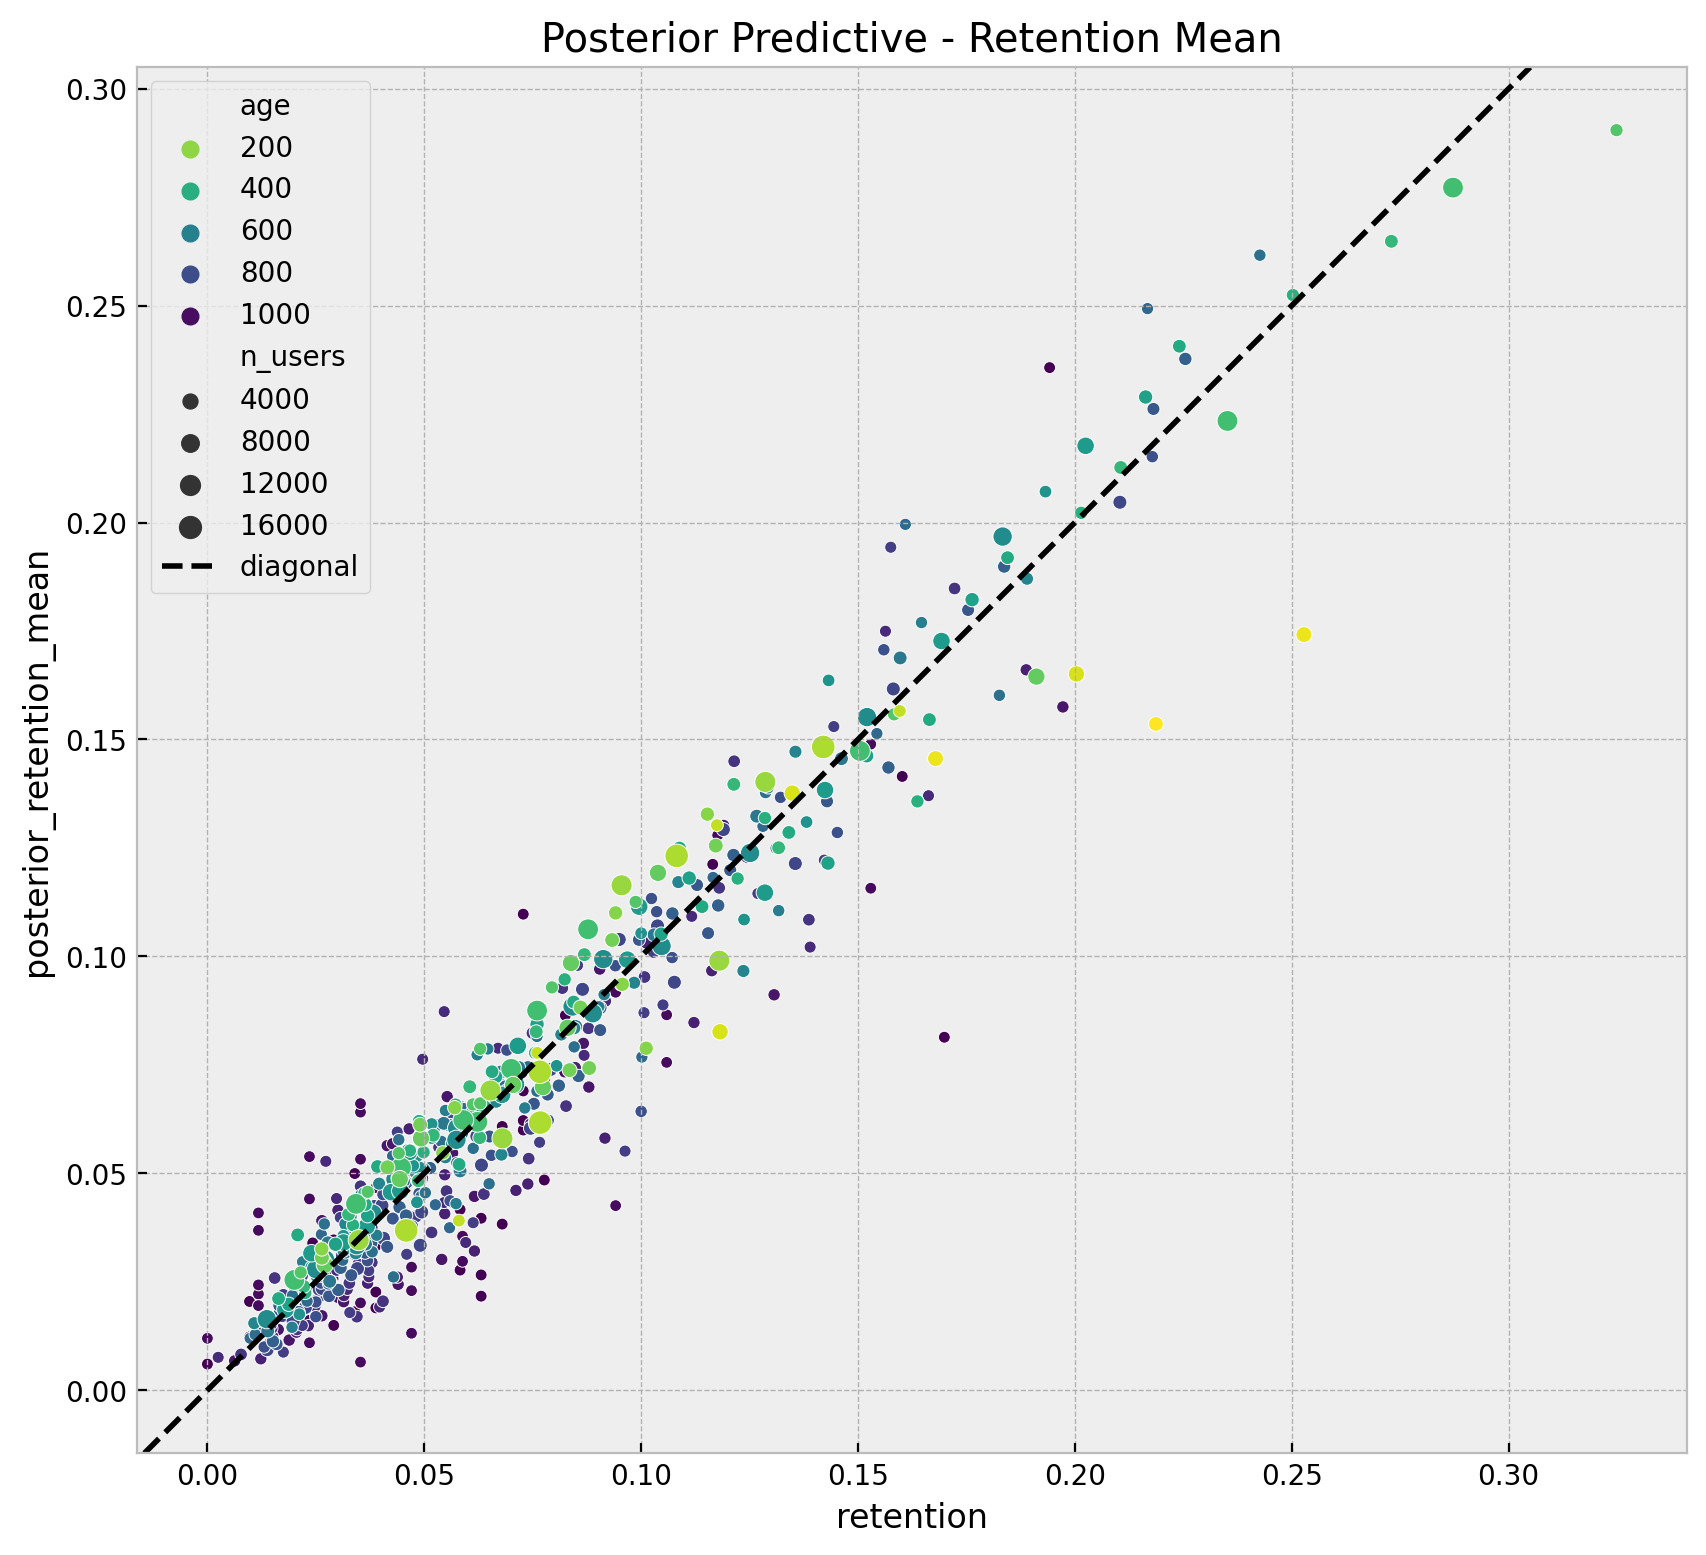

In [88]:
posterior_retention = (
    posterior_predictive.posterior_predictive / n_users[np.newaxis, None]
)
posterior_retention_mean = az.extract(data=posterior_retention, var_names=["likelihood"]).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=data_red_df.assign(posterior_retention_mean=posterior_retention_mean),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(title="Posterior Predictive - Retention Mean")


In [92]:
retention_hdi = az.hdi(ary=posterior_retention)["likelihood"]

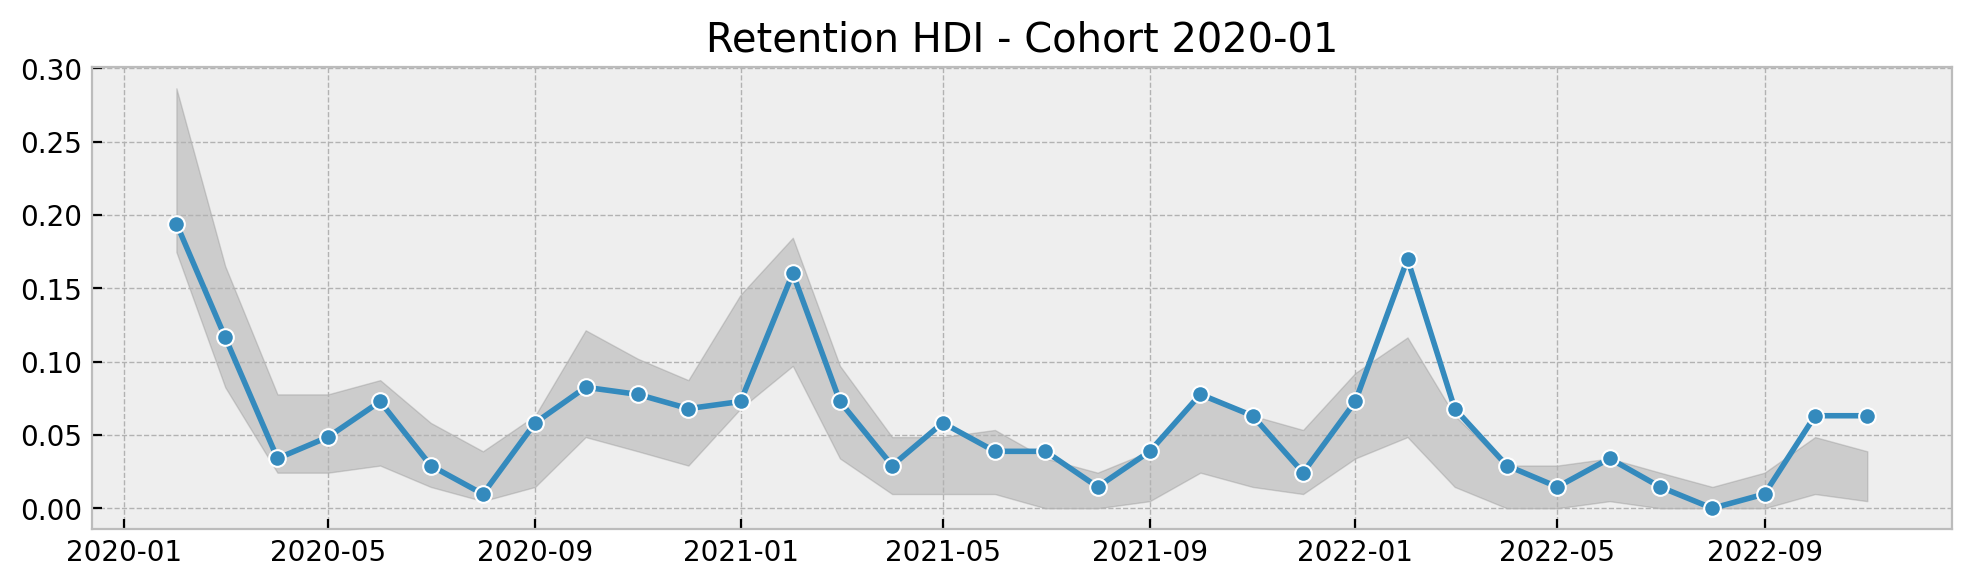

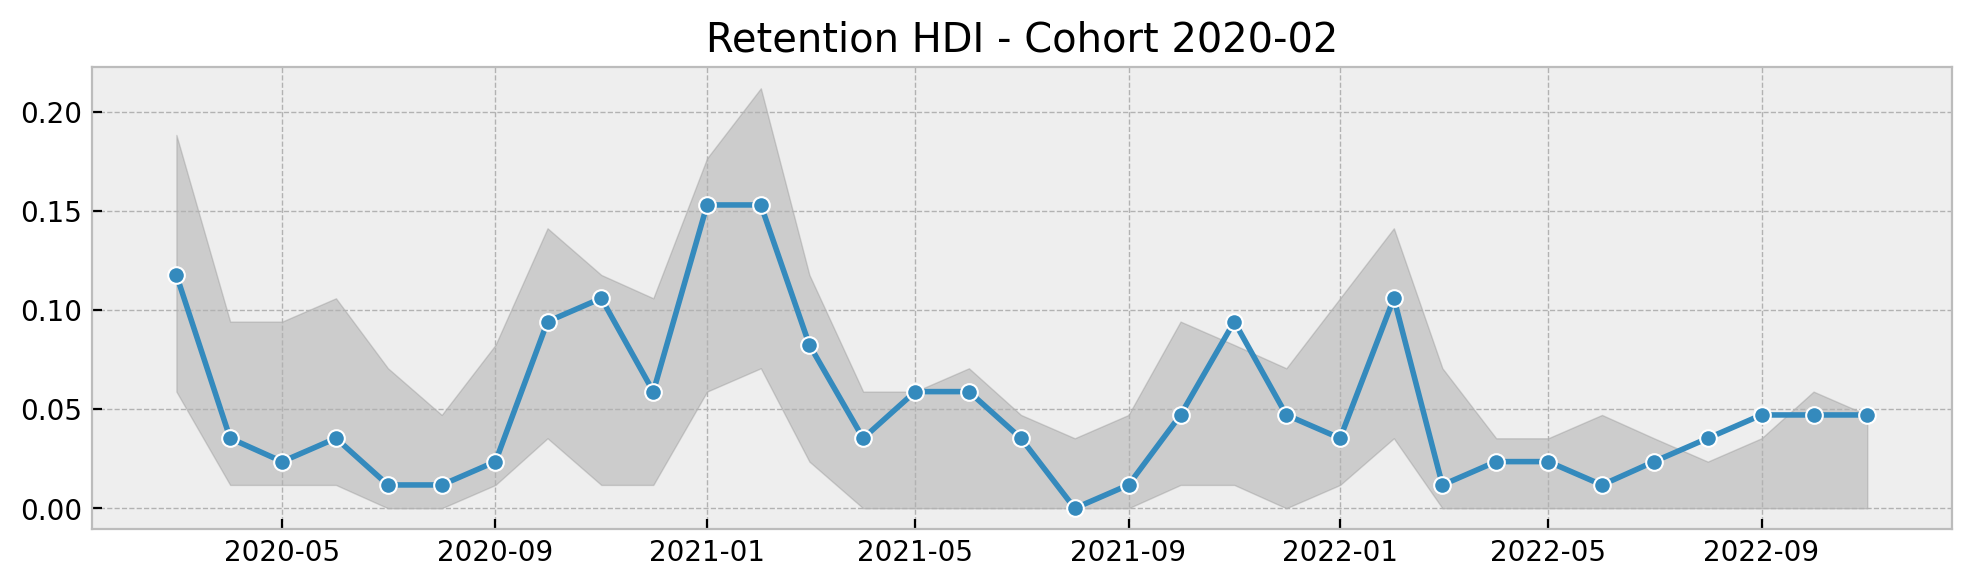

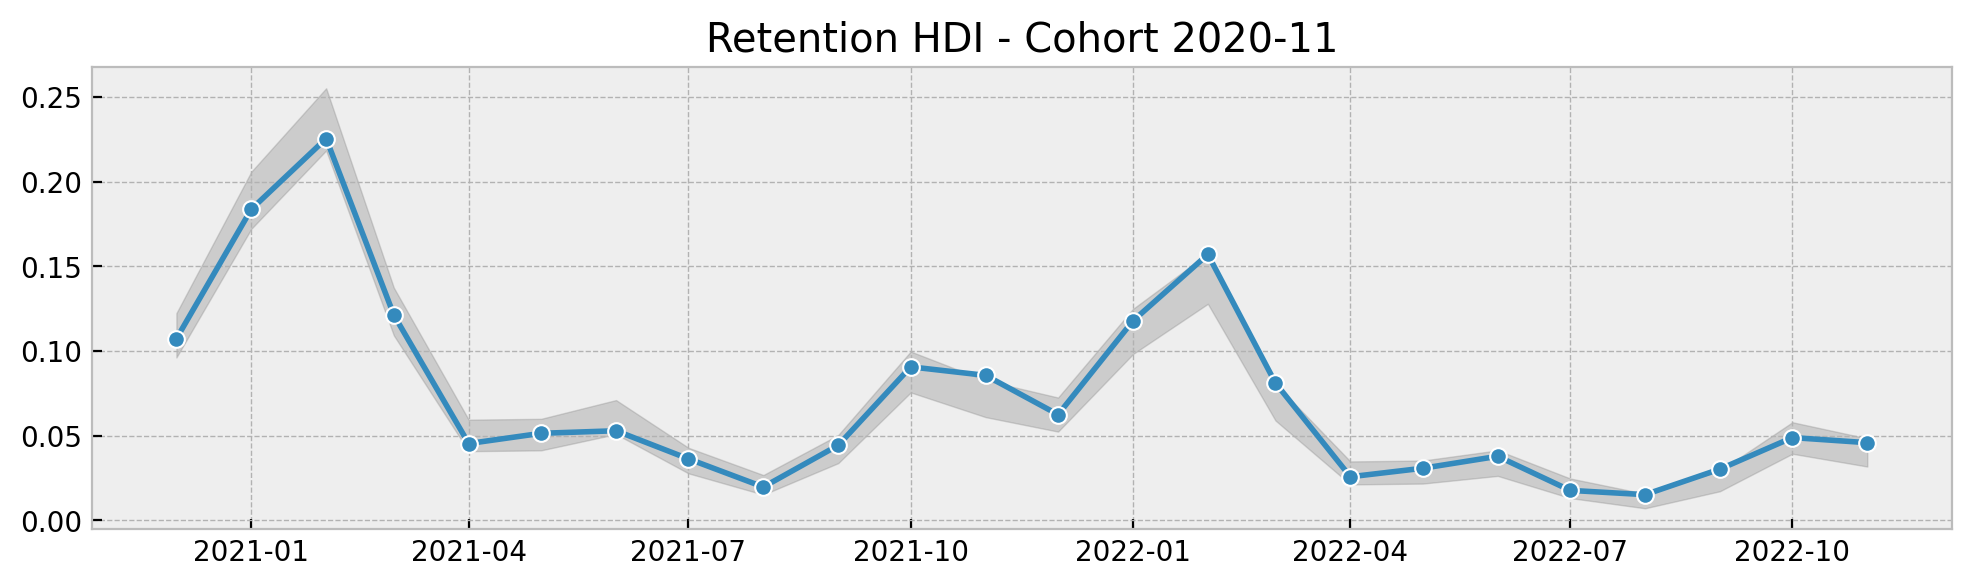

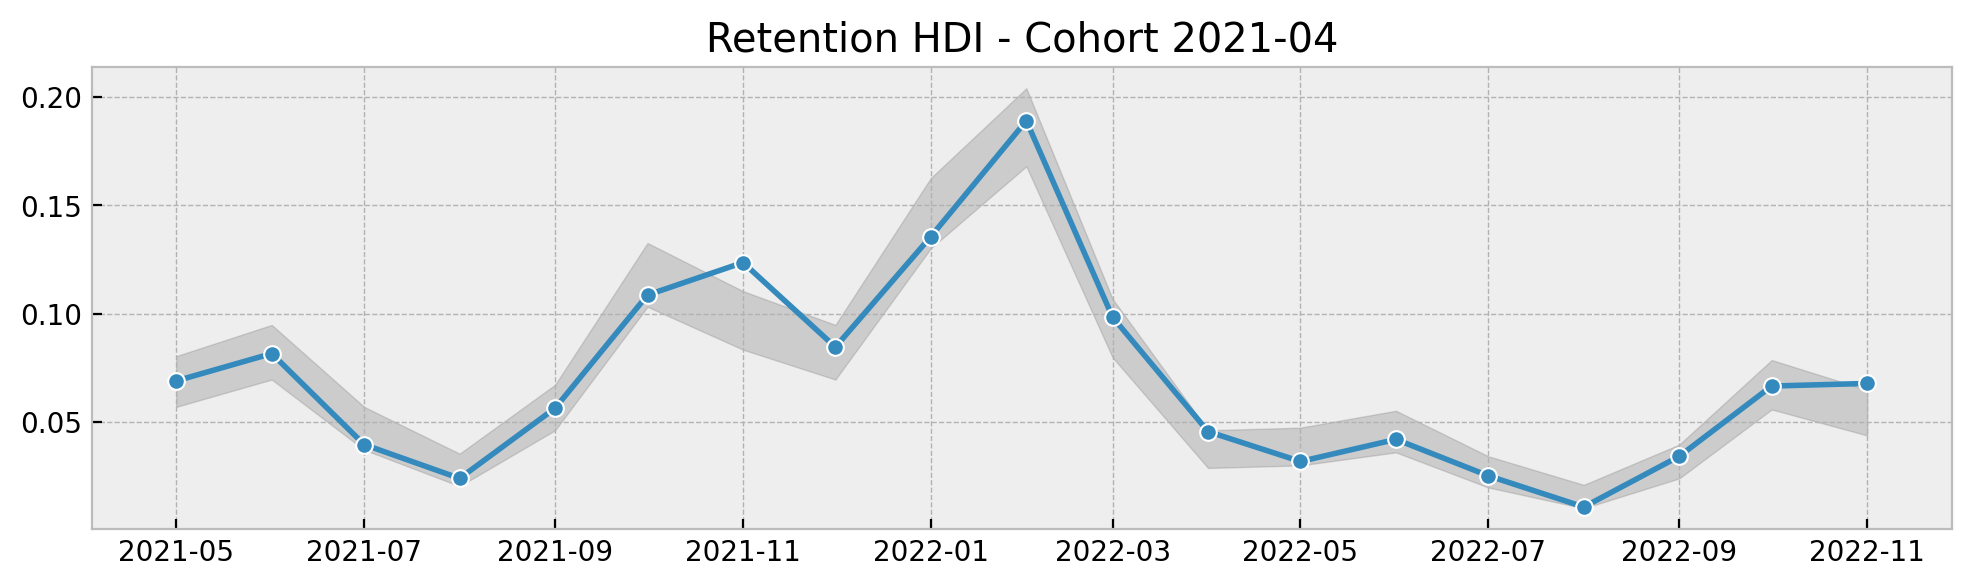

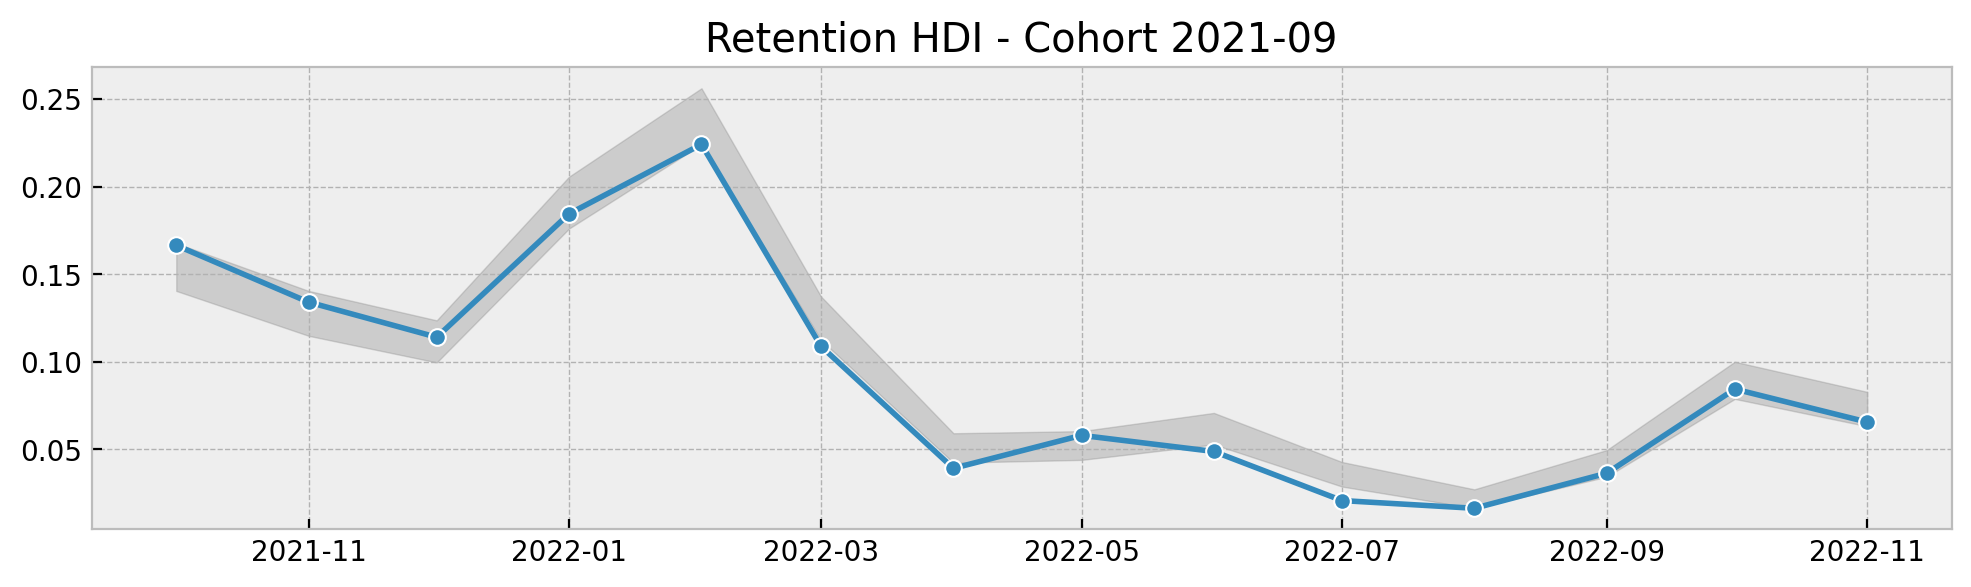

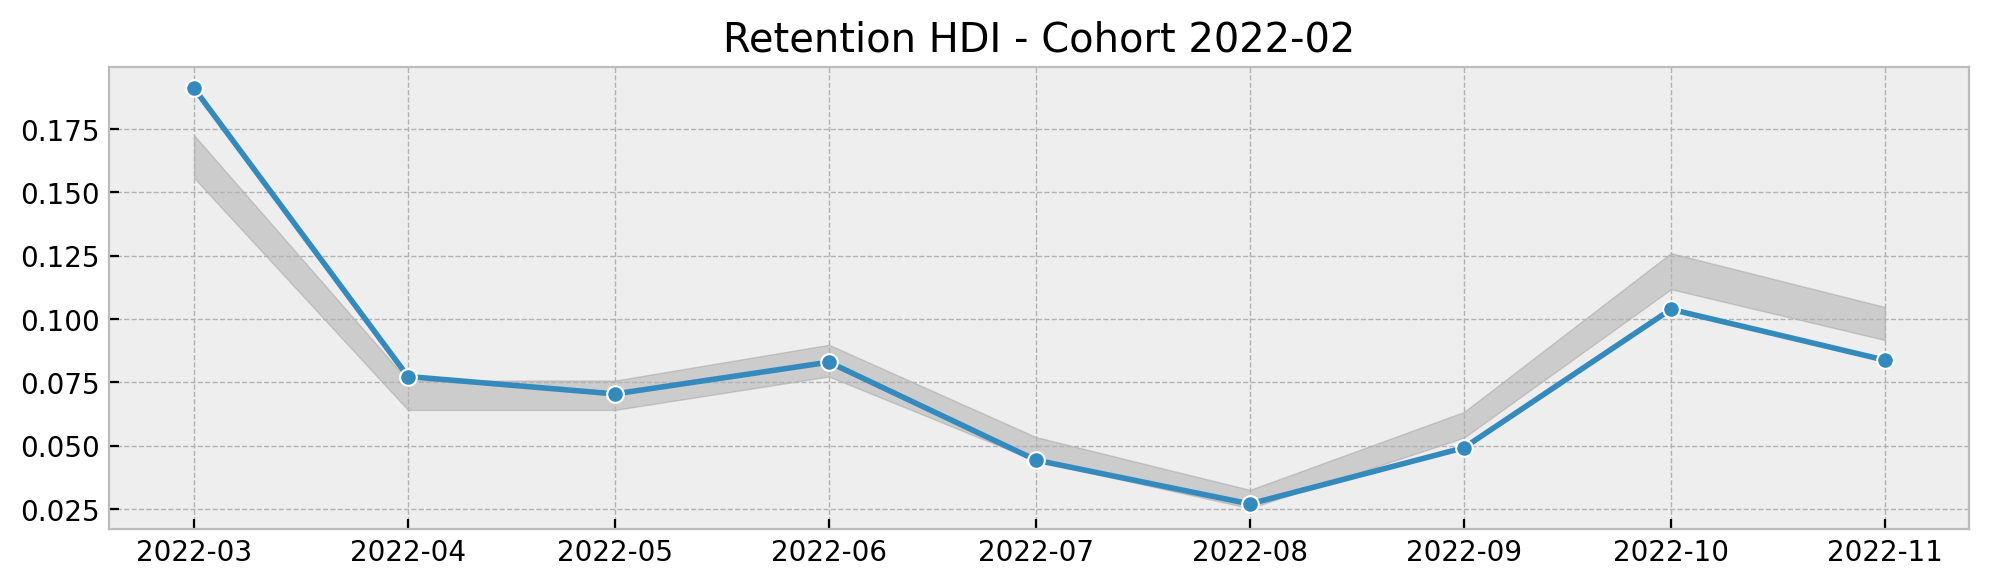

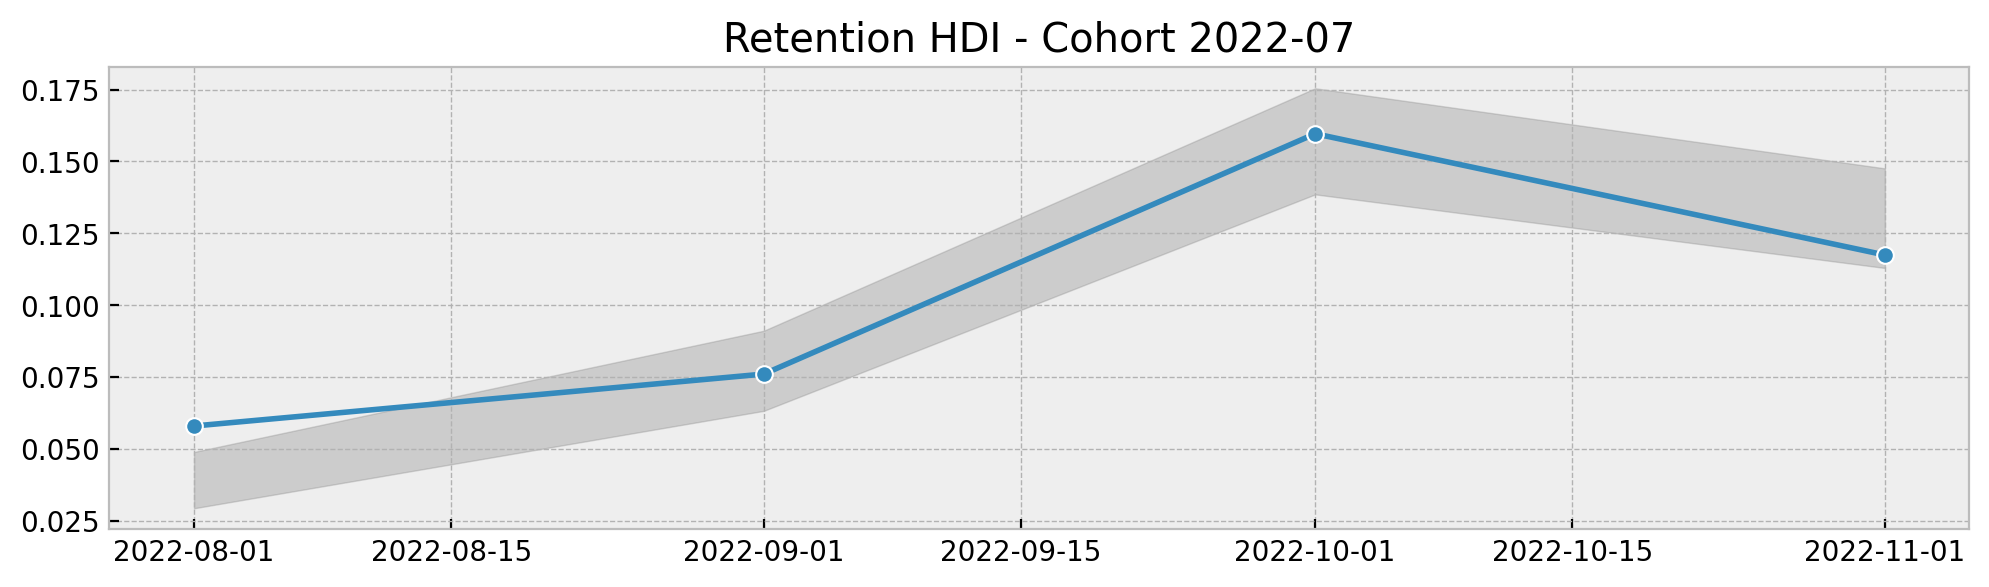

In [133]:
def plot_retention_hdi_cohort(cohort_index: int):

    mask = cohort_idx == cohort_index

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.fill_between(
        x=period[period_idx[mask]],
        y1=retention_hdi[mask, :][:, 0],
        y2=retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="gray",
    )
    sns.lineplot(
        x=period[period_idx[mask]], y=retention[mask], color="C0", marker="o", ax=ax
    )
    ax.set(title=f"Retention HDI - Cohort {cohort[cohort_index].strftime('%Y-%m')}")
    return ax


for i in [0, 1, 10, 15, 20, 25, 30]:
    plot_retention_hdi_cohort(cohort_index=i)